In [ ]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai

In [ ]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "qucikstart"

gemini_api_key = userdata.get("GEMINI_API_KEY")

In [ ]:
import os
from google.colab import userdata
gemini_api_key = userdata.get("GEMINI_API_KEY")

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm:ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model = "gemini-1.5-flash",
    max_retries = 2,
    api_key = gemini_api_key
)

llm.invoke("greet me")

AIMessage(content='Hello! How can I help you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-412bd56e-a42c-43e5-a77b-c6977f6a6c29-0', usage_metadata={'input_tokens': 3, 'output_tokens': 10, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

# Part 1: Build A Basic Chatbot:

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [ ]:
## Example usange of add_messages

new_messages_1 = [{"role": "user", "content": "Hello"}]
new_messages_2 = [{"role": "ai", "content": "Hi there"}]

messages = add_messages(new_messages_1, new_messages_2)
print("Updated State 1: ", messages)

Updated State 1:  [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='b2392fad-eeb6-4faa-bce2-31c0c7c357bb'), AIMessage(content='Hi there', additional_kwargs={}, response_metadata={}, id='692e5020-03e8-44d3-9bb9-8806d07df88c')]


In [ ]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [ ]:
graph_builder.add_edge(START, "chatbot")

In [ ]:
graph_builder.add_edge("chatbot", END)

In [ ]:
graph = graph_builder.compile()

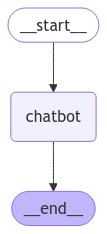

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
for event in graph.stream({"messages": [("user", "I am hamza")]}):
    print(event)
    print(event.values())
    print("EVENT:", list(event.values())[0]["messages"][-1].content)

{'chatbot': {'messages': [AIMessage(content='Nice to meet you, Hamza! \n\nWhat can I do for you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-5def92a6-6f14-4fc1-8fec-9dc8821029ad-0', usage_metadata={'input_tokens': 5, 'output_tokens': 17, 'total_tokens': 22, 'input_token_details': {'cache_read': 0}})]}}
dict_values([{'messages': [AIMessage(content='Nice to meet you, Hamza! \n\nWhat can I do for you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_rati

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hi my name is Hamza
Assistant: Hi Hamza, nice to meet you! 👋  What can I do for you today? 😊 

User: what is my name
Assistant: As an AI, I don't have access to personal information like your name.  To know your name, you'll need to tell me! 

User: q
Goodbye!


# Part 2: Enhancing Chatbot With Tools

In [ ]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [ ]:
os.environ ["TAVILY_API_KEY"] =  userdata.get("TAVILY_API_KEY")

### Next define the tool

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results = 2)

In [ ]:
tool.invoke("What's a 'node' in langgraph")

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"},
 {'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': 'Each node in a LangGraph graph has the ability to access, read, and write to the state. When a node modifies the state, it effectively broadcasts this information to all other nodes within the graph .'}]

In [ ]:
tools = [tool]

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification tell the LLM which tool it can call
ll_with_tools = llm.bind_tools(tool)

def chatbot(state:State)->State:
  return {"messages": [ll_with_tools.invoke(state['messages'])]}

graph_builder.add_node("chatbot", chatbot)

In [ ]:
ll_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), max_retries=2, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7cfc47b8c1c0>, default_metadata=()), kwargs={'tools': [{'function_declarations': [{'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type_': 6, 'description': 'Input for the Tavily tool.', 'properties': {'query': {'type_': 1, 'description': 'search query to look up', 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['query'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}]}]}, config={}, config_factories=[])

In [ ]:
ll_with_tools.invoke("What is langgraph")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "What is langgraph"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-15122b47-4300-40b6-a7e4-9b6efd01bfe5-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'What is langgraph'}, 'id': '1582e7a3-a7ff-49a9-9b02-d61353cb4278', 'type': 'tool_call'}], usage_metadata={'input_tokens': 78, 'output_tokens': 23, 'total_tokens': 101, 'input_token_details': {'cache_read': 0}})

In [ ]:
tools_by_name = {tool.name: tool for tool in tools}
print(type(tools_by_name))
print(tools_by_name)

<class 'dict'>
{'tavily_search_results_json': TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}


In [ ]:
tools_by_name["tavily_search_results_json"]

TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))

In [ ]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
                              # {"tavily_search_results_json": TavilySearchResult}
        self.tools_by_name = {tool.name: tool for tool in tools}


tool_node = BasicToolNode(tools=[tool])
print(tool_node.tools_by_name)

{'tavily_search_results_json': TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}


In [ ]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [
    AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "What is langgraph"}'}},
              response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]},
              id='run-15122b47-4300-40b6-a7e4-9b6efd01bfe5-0',
              tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'What is langgraph'}, 'id': '1582e7a3-a7ff-49a9-9b02-d61353cb4278', 'type': 'tool_call'}],
              usage_metadata={'input_tokens': 78, 'output_tokens': 23, 'total_tokens': 101, 'input_token_details': {'cache_read': 0}})
]

tool_node(inputs={"messages":messages})

{'messages': [ToolMessage(content='[{"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a framework for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with examples, integration with LangChain, and streaming support."}, {"url": "https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787", "content": "LangGraph is a low-level framework that offers extensive customisation options, allowing you to build precisely what you need. Since LangGraph is built on top of LangChain, it\'s seamlessly integrated into its ecosystem, making it easy to leverage existing tools and components. However, there are areas where LangGrpah could be improved:"}]', name='tavily_search_results_json', tool_call_id='1582e7a3-a7ff-49a9-9b02-d61353cb4278')]}

In [ ]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

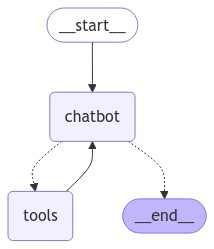

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hi 
Assistant: Hello! How can I help you today? 

User: what is current weather in Karachi
Assistant: 
Assistant: [{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Karachi', 'region': 'Sindh', 'country': 'Pakistan', 'lat': 24.8667, 'lon': 67.05, 'tz_id': 'Asia/Karachi', 'localtime_epoch': 1730751764, 'localtime': '2024-11-05 01:22'}, 'current': {'last_updated_epoch': 1730751300, 'last_updated': '2024-11-05 01:15', 'temp_c': 25.2, 'temp_f': 77.4, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 8.3, 'wind_kph': 13.3, 'wind_degree': 271, 'wind_dir': 'W', 'pressure_mb': 1013.0, 'pressure_in': 29.91, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 79, 'cloud': 0, 'feelslike_c': 26.6, 'feelslike_f': 79.9, 'windchill_c': 26.9, 'windchill_f': 80.5, 'heatindex_c': 28.7, 'heatindex_f': 83.7, 'dewpoint_c': 19.9, 'dewpoint_f': 67.9, 'vis_km': 6.0, 'vis_miles': 3.0, 'uv': 0.0, 'gust_mph

In [ ]:
from typing import Annotated


from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

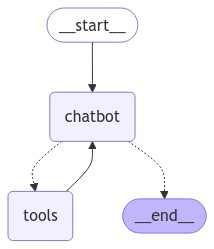

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hi
Assistant: Hello! 👋 How can I help you today? 😊 

User: who was the president of Pakistan
Assistant: 
Assistant: [{"url": "https://en.wikipedia.org/wiki/List_of_presidents_of_Pakistan", "content": "The president of Pakistan is the head of state of the Islamic Republic of Pakistan. The complete list of presidents of Pakistan includes the persons sworn into the office of president following the proclamation of the Islamic Republic of Pakistan in 1956. There have been a total of 13 presidents. The first president was Iskander Ali Mirza who"}, {"url": "https://president.gov.pk/", "content": "Latest News\nSpecial Initiatives\nGallery\nPresident Arif Alvi administers oath to Mian Muhammad Shehbaz Sharif as Prime Minister of Pakistan\nPresident for enhanced cooperation between audit institutions of Pakistan & Azerbaijan\nپنک سالٹ کو عالمی سطح پر  موثر انداز میں پاکستانی نمک کے طور پر مارکیٹ کرنا ہوگا، صدر مملکت\nکرتار پور راہداری امن کی علامت، پاکستان تمام سکھ یاتریوں کو خوش آمدید کہ

#Part 3: Adding Memory To The Chatbot

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off.

We will see later that **checkpointing** is much more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But before we get too ahead of ourselves, let's add checkpointing to enable multi-turn conversations.

To get started, create a `MemorySaver` checkpointer.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memroy = MemorySaver()

**Notice** we're using an in-memory checkpointer. This is convenient for our tutorial (it saves it all in-memory). In a production application, you would likely change this to use `SqliteSaver` or `PostgresSaver` and connect to your own DB.

Next define the graph. Now that you've already built your own `BasicToolNode`, we'll replace it with LangGraph's prebuilt `ToolNode` and `tools_condition`, since these do some nice things like parallel API execution. Apart from that, the following is all copied from Part 2.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
  messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state:State):
  return {"messages": [llm_with_tools.invoke(state['messages'])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

In [ ]:
graph = graph_builder.compile(checkpointer=memroy)

Notice the connectivity of the graph hasn't changed since Part 2. All we are doing is checkpointing the `State` as the graph works through each node.

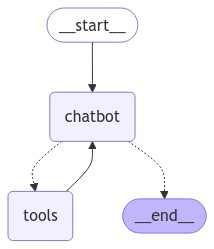

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now you can interact with your bot! First, pick a thread to use as the key for this conversation.

In [ ]:
config = {"configurable": {"thread_id": "1"}}

Next, call your chat bot.

In [ ]:
user_input = "Hi there! My name is Hamza."
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Hamza.
================================== Ai Message ==================================

Nice to meet you, Hamza! How can I help you today?


**Note**: The config was provided as the **second positional argument** when calling our graph. It importantly is not nested within the graph inputs `({'messages': []}).`

Let's ask a followup: see if it remembers your name.

In [ ]:
user_input = "Remember my name?"
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I will try my best to remember your name, Hamza!  Is there anything specific you would like to talk about or ask me? 😊


**Notice** that we aren't using an external list for memory: it's all handled by the checkpointer! You can inspect the full execution in this `LangSmith trace` to see what's going on.

Don't believe me? Try this using a different config.

In [ ]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", "What is my name?")]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I do not have access to personal information about you, including your name. I am a language model and do not have the ability to store or retrieve personal data.


**Notice** that the **only** change we've made is to modify the `thread_id` in the config. See this call's ```LangSmith trace``` for comparison.

By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's `state` for a given config at any time, call `get_state(config)`.

In [ ]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Hamza.', additional_kwargs={}, response_metadata={}, id='b16c5dba-0ce5-45b2-86a6-e470201db59f'), AIMessage(content='Nice to meet you, Hamza! How can I help you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-d6f7e7eb-b4c1-4f7a-8fea-7dd656e2ce5b-0', usage_metadata={'input_tokens': 82, 'output_tokens': 14, 'total_tokens': 96, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Remember my name?', additional_kwargs=

In [ ]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)


()

The snapshot above contains the current state values, corresponding config, and the `next` node to process. In our case, the graph has reached an `END` state, so `next` is empty.

# Part 4: Human In The Loop

Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

LangGraph supports `human-in-the-loop` workflows in a number of ways. In this section, we will use LangGraph's `interrupt_before` functionality to always break the tool node.

First, start from our existing code. The following is copied from Part 3.

In [ ]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")


Now, compile the graph, specifying to `interrupt_before` the `tools` node.

In [ ]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

In [ ]:
user_input = "I am learning Langgraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "3"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
  if "messages" in event:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I am learning Langgraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (dc7a67f6-ad9e-4199-b60e-f3560f6e7ff8)
 Call ID: dc7a67f6-ad9e-4199-b60e-f3560f6e7ff8
  Args:
    query: Langgraph


Let's inspect the graph state to confirm it worked.

In [ ]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [ ]:
snapshot.config

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9baf1-289e-6fe1-8001-149ee0ec67ae'}}

In [ ]:
snapshot.values

{'messages': [HumanMessage(content='I am learning Langgraph. Could you do some research on it for me?', additional_kwargs={}, response_metadata={}, id='62b6bf0a-6cd7-4b17-bb40-f79a053a7f87'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "Langgraph"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-552d050b-9532-4db8-b367-44205aff8bd5-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Langgraph'}, 'id': 'dc7a67f6-ad9e-4199-b60e-f3560f6

In [ ]:
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (dc7a67f6-ad9e-4199-b60e-f3560f6e7ff8)
 Call ID: dc7a67f6-ad9e-4199-b60e-f3560f6e7ff8
  Args:
    query: Langgraph


**Notice** that unlike last time, the "next" node is set to **'tools'**. We've interrupted here! Let's check the tool invocation.

In [ ]:
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'Langgraph'},
  'id': 'dc7a67f6-ad9e-4199-b60e-f3560f6e7ff8',
  'type': 'tool_call'}]

This query seems reasonable. Nothing to filter here. The simplest thing the human can do is just let the graph continue executing. Let's do that below.

Next, continue the graph! Passing in `None` will just let the graph continue where it left off, without adding anything new to the state.

In [ ]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (dc7a67f6-ad9e-4199-b60e-f3560f6e7ff8)
 Call ID: dc7a67f6-ad9e-4199-b60e-f3560f6e7ff8
  Args:
    query: Langgraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a framework for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with LangChain, LangSmith, and Anthropic tools to build agent and multi-agent workflows."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and sta

#Part 5: Manually Updating The State

In the previous section, we showed how to interrupt a graph so that a human could inspect its actions. This lets the human `read` the state, but if they want to change their agent's course, they'll need to have `write` access.

Thankfully, LangGraph lets you **manually update state**! Updating the state lets you control the agent's trajectory by modifying its actions (even modifying the past!). This capability is particularly useful when you want to correct the agent's mistakes, explore alternative paths, or guide the agent towards a specific goal.

We'll show how to update a checkpointed state below. As before, first, define your graph. We'll reuse the exact same graph as before.

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "4"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (b9e24fed-e2ab-4819-84a3-d55608ca11c3)
 Call ID: b9e24fed-e2ab-4819-84a3-d55608ca11c3
  Args:
    query: LangGraph


In [ ]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (50fcaf6c-7092-48ce-9df8-9be35a1f059e)
 Call ID: 50fcaf6c-7092-48ce-9df8-9be35a1f059e
  Args:
    query: LangGraph


So far, all of this is an exact repeat of the previous section. The LLM just requested to use the search engine tool and our graph was interrupted. If we proceed as before, the tool will be called to search the web.

But what if the user wants to intercede? What if we think the chat bot doesn't need to use the tool?

Let's directly provide the correct response!

In [ ]:
# just for example
from langchain_core.messages import AIMessage, ToolMessage

abc = ToolMessage(content="Hi i am ToolMessage Response", tool_call_id="123")
abc

ToolMessage(content='Hi i am ToolMessage Response', tool_call_id='123')

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]


In [ ]:
new_messages[-1].pretty_print()

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


In [ ]:
for m in new_messages:
    m.pretty_print()

================================= Tool Message =================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.
================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


In [ ]:
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='a8732ffc-bd88-404f-86dc-7a4bee1afa50', tool_call_id='50fcaf6c-7092-48ce-9df8-9be35a1f059e'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='aef81000-9e33-4ad1-bc8b-e998809f4bc2')]


In [ ]:
for m in graph.get_state(config).values["messages"]:
    m.pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (50fcaf6c-7092-48ce-9df8-9be35a1f059e)
 Call ID: 50fcaf6c-7092-48ce-9df8-9be35a1f059e
  Args:
    query: LangGraph
================================= Tool Message =================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.
================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


In [ ]:
snapshot = graph.get_state(config)
snapshot.next

()

Now the graph is complete, since we've provided the final response message! Since state updates simulate a graph step, they even generate corresponding traces. Inspec the `LangSmith trace` of the `update_state` call above to see what's going on.

**Notice** that our new messages are appended to the messages already in the `state`. Remember how we defined the State type?

class State(TypedDict):
      messages: Annotated[list, add_messages]

We annotated `messages` with the pre-built `add_messages` function. This instructs the graph to always append values to the existing list, rather than overwriting the list directly. The same logic is applied here, so the messages we passed to `update_state` were appended in the same way!

The `update_state` function operates as if it were one of the nodes in your graph! By default, the update operation uses the node that was last executed, but you can manually specify it below. Let's add an update and tell the graph to treat it as if it came from the "chatbot".

In [ ]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9bc46-3b4f-650b-8004-0a82afcfe42b'}}

In [ ]:
for m in graph.get_state(config).values["messages"]:
    m.pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (50fcaf6c-7092-48ce-9df8-9be35a1f059e)
 Call ID: 50fcaf6c-7092-48ce-9df8-9be35a1f059e
  Args:
    query: LangGraph
================================= Tool Message =================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.
================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.
================================== Ai Message ==================================

I'm an AI expert!


Check out the LangSmith trace for this update call at the provided link. **Notice** from the trace that the graph continues into the `tools_condition` edge. We just told the graph to treat the update `as_node="chatbot"`. If we follow the diagram below and start from the `chatbot` node, we naturally end up in the `tools_condition` edge and then `__end__` since our updated message lacks tool calls.

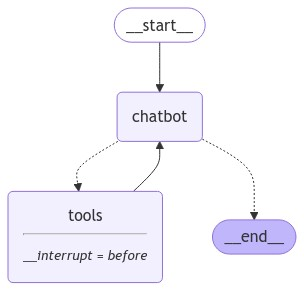

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Inspect the current state as before to confirm the checkpoint reflects our manual updates.

In [ ]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='a8732ffc-bd88-404f-86dc-7a4bee1afa50', tool_call_id='50fcaf6c-7092-48ce-9df8-9be35a1f059e'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='aef81000-9e33-4ad1-bc8b-e998809f4bc2'), AIMessage(content="I'm an AI expert!", additional_kwargs={}, response_metadata={}, id='4d1765d6-19e7-4d54-9185-c420991508cf')]
()


**Notice**: that we've continued to add AI messages to the state. Since we are acting as the `chatbot` and responding with an AIMessage that doesn't contain `tool_calls`, the graph knows that it has entered a finished state (`next` is empty).

##What if you want to **overwrite** existing messages?
The `add_messages` function we used to annotate our graph's `State` above controls how updates are made to the `messages` key. This function looks at any message IDs in the new `messages` list. If the ID matches a message in the existing state, `add_messages` overwrites the existing message with the new content.

As an example, let's update the tool invocation to make sure we get good results from our search engine! First, start a new thread:

In [ ]:
# Just for example
from langchain_core.messages import HumanMessage
user_query = [HumanMessage(id=1, content="I want to learn Langchain and learn more about it")]
updated_user_query = [HumanMessage(id=1, content="I want to learn Langgraph and learn more about it")]

In [ ]:
final_query = add_messages(user_query, updated_user_query)
final_query

[HumanMessage(content='I want to learn Langgraph and learn more about it', additional_kwargs={}, response_metadata={}, id='1')]

In [ ]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "5"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
  if "messages" in event:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (920ce834-6009-4882-956f-5462917baad1)
 Call ID: 920ce834-6009-4882-956f-5462917baad1
  Args:
    query: LangGraph


**Next**, let's update the tool invocation for our agent. Maybe we want to search for human-in-the-loop workflows in particular.

In [ ]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)

In [ ]:
existing_messages = snapshot.values["messages"][-1]
print("Original")
print(existing_messages.pretty_print())
print("Message ID:", existing_messages.id)
print(existing_messages.tool_calls[0])

Original
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (920ce834-6009-4882-956f-5462917baad1)
 Call ID: 920ce834-6009-4882-956f-5462917baad1
  Args:
    query: LangGraph
None
Message ID: run-215b3f72-6430-4949-8261-6c8a8763781c-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': '920ce834-6009-4882-956f-5462917baad1', 'type': 'tool_call'}


In [ ]:
new_tool_call = existing_messages.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_messages.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_messages.id,
)

In [ ]:
new_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (920ce834-6009-4882-956f-5462917baad1)
 Call ID: 920ce834-6009-4882-956f-5462917baad1
  Args:
    query: LangGraph human-in-the-loop workflow


In [ ]:
print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)

Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': '920ce834-6009-4882-956f-5462917baad1', 'type': 'tool_call'}
Message ID run-215b3f72-6430-4949-8261-6c8a8763781c-0


In [ ]:
graph.update_state(config, {"messages": [new_message]})
print("\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': '920ce834-6009-4882-956f-5462917baad1',
  'type': 'tool_call'}]

In [ ]:
for m in graph.get_state(config).values["messages"]:
  m.pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (920ce834-6009-4882-956f-5462917baad1)
 Call ID: 920ce834-6009-4882-956f-5462917baad1
  Args:
    query: LangGraph human-in-the-loop workflow


**Notice** that we've modified the AI's tool invocation to search for "LangGraph human-in-the-loop workflow" instead of the simple "LangGraph".

Check out the LangSmith trace to see the state update call - you can see our new message has successfully updated the previous AI message.

Resume the graph by streaming with an input of `None` and the existing config.

In [ ]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (920ce834-6009-4882-956f-5462917baad1)
 Call ID: 920ce834-6009-4882-956f-5462917baad1
  Args:
    query: LangGraph human-in-the-loop workflow
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.js-craft.io/blog/human-loop-langgraph-javascript/", "content": "Human-in-the-Loop in LangGraph (JavaScript version) When discussing AI agents, one concept we can't overlook is Human-in-the-Loop (HITL). Human-in-the-Loop refers to the active involvement of humans in the decision-making processes of AI agents. There are several ways to integrate humans into the AI loop. One common method is authorization, where the AI agent requires human approval for specific actions before proceeding. Another key interaction type is continuous feedback loops, where humans provide guidance throughout the AI’s 

Check out the trace to see the tool call and later LLM response. **Notice** that now the graph queries the search engine using our updated query term - we were able to manually override the LLM's search here!

All of this is reflected in the graph's checkpointed memory, meaning if we continue the conversation, it will recall all the modified state.

In [ ]:
events = graph.stream(
    {"messages":("user", "Remember what I'm learning about?")}, config, stream_mode="values"
)
for event in events:
  if "messages" in event:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember what I'm learning about?
================================== Ai Message ==================================

You're learning about LangGraph, a tool for building AI agents that allows human input and uses a "Human-in-the-Loop" workflow for feedback and guidance.


In [ ]:
for m in graph.get_state(config).values["messages"]:
  m.pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (920ce834-6009-4882-956f-5462917baad1)
 Call ID: 920ce834-6009-4882-956f-5462917baad1
  Args:
    query: LangGraph human-in-the-loop workflow
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.js-craft.io/blog/human-loop-langgraph-javascript/", "content": "Human-in-the-Loop in LangGraph (JavaScript version) When discussing AI agents, one concept we can't overlook is Human-in-the-Loop (HITL). Human-in-the-Loop refers to the active involvement of humans in the decision-making processes of AI agents. There are several ways to integrate humans into the AI loop. One common method is authorization, where the AI agent requires human approval fo

#Part 6: Customizing State
So far, we've relied on a simple state (it's just a list of messages!). You can go far with this simple state, but if you want to define complex behavior without relying on the message list, you can add additional fields to the state. In this section, we will extend our chat bot with a new node to illustrate this.

In the examples above, we involved a human deterministically: the graph **always** interrupted whenever an tool was invoked. Suppose we wanted our chat bot to have the choice of relying on a human.

One way to do this is to create a passthrough "human" node, before which the graph will always stop. We will only execute this node if the LLM invokes a "human" tool. For our convenience, we will include an "ask_human" flag in our graph state that we will flip if the LLM calls this tool.

Below, define this new graph, with an updated `State`

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

Next, define a schema to show the model to let it decide to request assistance.

Using Pydantic with LangChain

This notebook uses Pydantic v2 `BaseModel`, which requires `langchain-core >= 0.3`. Using `langchain-core < 0.3` will result in errors due to mixing of Pydantic v1 and v2 `BaseModels`.

In [ ]:
from pydantic import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

In [ ]:
abc = RequestAssistance(request="I need help")
print(abc)

request='I need help'


In [ ]:
abc.request

'I need help'

Next, define the chatbot node. The primary modification here is flip the `ask_human` flag if we see that the chat bot has invoked the `RequestAssistance` flag.

In [ ]:
tool = TavilySearchResults(max_results=2)
tools = [tool]

# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

In [ ]:
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), max_retries=2, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7edb996cc1f0>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'RequestAssistance', 'description': "Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.\n\nTo use this function, relay the user's 'request' so the exper

In [ ]:
result = llm_with_tools.invoke("Connect me with a langgraph expert for paid project")
result.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (e58ee10d-9e87-4224-969e-46410a88a052)
 Call ID: e58ee10d-9e87-4224-969e-46410a88a052
  Args:
    request: Connect me with a langgraph expert for paid project


In [ ]:
result = llm_with_tools.invoke("Search about Langgraph")
result.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (ec8b1874-8f6e-4d3d-8ebd-de3c6ec1cc8b)
 Call ID: ec8b1874-8f6e-4d3d-8ebd-de3c6ec1cc8b
  Args:
    query: Langgraph


In [ ]:
def chatbot(state: State):
  response = llm_with_tools.invoke(state["messages"])
  ask_human = False
  if (
  response.tool_calls
  and response.tool_calls[0]["name"] == RequestAssistance.__name__
  ):
    ask_human = True
  return {"messages": [response], "ask_human": ask_human}

Next, create the graph builder and add the chatbot and tools nodes to the graph, same as before.

In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

Next, create the "human" `node`. This `node` function is mostly a placeholder in our graph that will trigger an interrupt. If the human does **not** manually update the state during the `interrupt`, it inserts a tool message so the LLM knows the user was requested but didn't respond. This node also unsets the `ask_human` flag so the graph knows not to revisit the node unless further requests are made.

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

Next, define the conditional logic. `The select_next_node` will route to the `human` node if the flag is set. Otherwise, it lets the prebuilt `tools_condition` function choose the next node.

Recall that the `tools_condition` function simply checks to see if the `chatbot` has responded with any `tool_calls` in its response message. If so, it routes to the `action` node. Otherwise, it ends the graph.

In [ ]:
def select_next_node(state:State):
  # if in state value ask_human is True
  if state["ask_human"]:
    return "human"
  # Otherwise, we can route as before
  return tools_condition(state)

graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

Finally, add the simple directed edges and compile the graph. These edges instruct the graph to **always** flow from node `a`->`b` whenever `a` finishes executing.

In [ ]:
# The rest is the same
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

If you have the visualization dependencies installed, you can see the graph structure below:

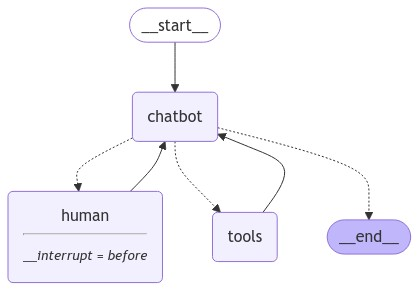

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

The chat bot can either request help from a human (chatbot->select->human), invoke the search engine tool (chatbot->select->action), or directly respond (chatbot->select->**end**). Once an action or request has been made, the graph will transition back to the `chatbot` node to continue operations.

Let's see this graph in action. We will request for expert assistance to illustrate our graph.

In [ ]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "6"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (539711a5-0e9a-4b58-a918-27a8641b9450)
 Call ID: 539711a5-0e9a-4b58-a918-27a8641b9450
  Args:
    request: I need some expert guidance for building this AI agent.


**Notice**: the LLM has invoked the `"RequestAssistance"` tool we provided it, and the interrupt has been set. Let's inspect the graph state to confirm.

In [ ]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

The graph state is indeed **interrupted** before the `'human'` node. We can act as the "expert" in this scenario and manually update the state by adding a new ToolMessage with our input.

Next, respond to the chatbot's request by:

1.Creating a `ToolMessage` with our response. This will be passed back to the `chatbot`.

2.Calling `update_state` to manually update the graph state.

In [ ]:
# we need a too_calls_id to create a ToolMessage we get a tool call id for ai_message
ai_message = snapshot.values["messages"][-1]
ai_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (539711a5-0e9a-4b58-a918-27a8641b9450)
 Call ID: 539711a5-0e9a-4b58-a918-27a8641b9450
  Args:
    request: I need some expert guidance for building this AI agent.


In [ ]:
human_response = (
     "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
     " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)

In [ ]:
tool_message

ToolMessage(content="We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.", tool_call_id='539711a5-0e9a-4b58-a918-27a8641b9450')

In [ ]:
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '6',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9c554-96fc-6ca6-8002-6c7509c80f80'}}

You can inspect the state to confirm our response was added.

In [ ]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='38f7426b-fe86-4f64-b176-7360f3ab31e4'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'RequestAssistance', 'arguments': '{"request": "I need some expert guidance for building this AI agent."}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-ee0b246f-46ec-4eb6-a146-13926ce471f0-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need


**Next**, resume the graph by invoking it with `None` as the inputs.

In [ ]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Okay, I've requested assistance from an expert. They recommend checking out LangGraph for building your AI agent. It's apparently more reliable and extensible than simple autonomous agents.


In [ ]:
for m in graph.get_state(config).values["messages"]:
  m.pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (539711a5-0e9a-4b58-a918-27a8641b9450)
 Call ID: 539711a5-0e9a-4b58-a918-27a8641b9450
  Args:
    request: I need some expert guidance for building this AI agent.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Okay, I've requested assistance from an expert. They recommend checking out LangGraph for building your AI agent. It's apparently more reliable and extensible than simple autonomous agents.


**Notice** that the chat bot has incorporated the updated state in its final response. Since **everything** was checkpointed, the "expert" human in the loop could perform the update at any time without impacting the graph's execution.

# Part 7: Time Travel

In a typical chat bot workflow, the user interacts with the bot 1 or more times to accomplish a task. In the previous sections, we saw how to add memory and a human-in-the-loop to be able to checkpoint our graph state and manually override the state to control future responses.

But what if you want to let your user start from a previous response and "branch off" to explore a separate outcome? Or what if you want users to be able to "rewind" your assistant's work to fix some mistakes or try a different strategy (common in applications like autonomous software engineers)?

You can create both of these experiences and more using LangGraph's built-in "time travel" functionality.

In this section, you will "rewind" your graph by fetching a checkpoint using the graph's `get_state_history` method. You can then resume execution at this previous point in time.

First, recall our chatbot graph. We don't need to make **any** changes from before:

In [ ]:
from typing import Annotated, Literal

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage

# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

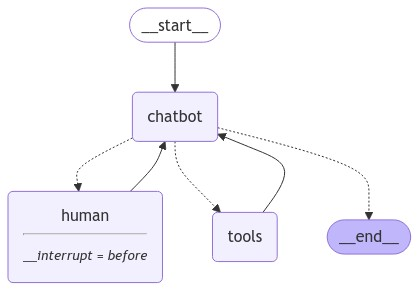

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's have our graph take a couple steps. Every step will be checkpointed in its state history:

In [ ]:
config = {"configurable": {"thread_id": "7"}}
events = graph.stream(
    {
        "messages": [
            ("user", "Hi! I am learning AI Agents")
        ]
    },
    config,
    stream_mode = "values",
)
for event in events:
  if "messages" in event:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! I am learning AI Agents
================================== Ai Message ==================================

That's great! AI agents are a fascinating field. What specifically are you interested in learning about them?


In [ ]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That's an ambitious and exciting goal! Building an autonomous agent is a great way to delve deeper into AI. To help you get started, could you tell me more about what kind of autonomous agent you have in mind? 

For example:

* **What tasks would your agent perform?** (e.g., playing a game, managing a schedule, controlling a robot, etc.)
* **What kind of environment would your agent operate in?** (e.g., a virtual world, a physical space, a simulated environment, etc.)
* **What kind of learning capabilities would your agent need?** (e.g., reinforcement learning, supervised learning, unsupervised learning, etc.)

The more details you can provide, the better I can understand your vision and offer relevant guidance!


Now that we've had the agent take a couple steps, we can `replay` the full state history to see everything that occurred.

In [ ]:
to_replay = []
for state in graph.get_state_history(config):
  print(state)
  to_replay.append(state)

StateSnapshot(values={'messages': [HumanMessage(content='Hi! I am learning AI Agents', additional_kwargs={}, response_metadata={}, id='e9f67ba9-c72f-44ff-ab65-8cace8278899'), AIMessage(content="That's great! AI agents are a fascinating field. What specifically are you interested in learning about them? \n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-5cac4a50-cd0c-45c5-a8ec-294b45c84a18-0', usage_metadata={'input_tokens': 162, 'output_tokens': 22, 'total_tokens': 184, 'input_token_details': {'cache_read': 0}}),

In [ ]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 1:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


**Notice** that checkpoints are saved for every step of the graph. This **spans invocations** so you can rewind across a full thread's history. We've picked out `to_replay` as a state to resume from. This is the state after the `chatbot` node in the second graph invocation above.

Resuming from this point should call the **action** node next.

In [ ]:
print(to_replay.next)
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': '7', 'checkpoint_ns': '', 'checkpoint_id': '1ef9e1e0-6fc0-640a-8000-76a2a376272f'}}


In [ ]:
print(to_replay)

StateSnapshot(values={'messages': [HumanMessage(content='Hi! I am learning AI Agents', additional_kwargs={}, response_metadata={}, id='e9f67ba9-c72f-44ff-ab65-8cace8278899')]}, next=('chatbot',), config={'configurable': {'thread_id': '7', 'checkpoint_ns': '', 'checkpoint_id': '1ef9e1e0-6fc0-640a-8000-76a2a376272f'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '7', 'step': 0, 'parents': {}}, created_at='2024-11-08T22:08:47.516127+00:00', parent_config={'configurable': {'thread_id': '7', 'checkpoint_ns': '', 'checkpoint_id': '1ef9e1e0-6fbb-6b35-bfff-91e48b17b639'}}, tasks=(PregelTask(id='834f1825-f5b8-4b9c-4773-093480d32ccd', name='chatbot', path=('__pregel_pull', 'chatbot'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content="That's great! AI agents are a fascinating field. What specifically are you interested in learning about them? \n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finis

**Notice** that the checkpoint's config `(to_replay.config)` contains a `checkpoint_id` **timestamp**. Providing this `checkpoint_id` value tells LangGraph's checkpointer to **load** the state from that moment in time. Let's try it below:

In [ ]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! I am learning AI Agents
================================== Ai Message ==================================

That's great! AI agents are a fascinating field. What specifically are you interested in learning about?


**Notice** that the graph resumed execution from the `**action**` node. You can tell this is the case since the first value printed above is the response from our search engine tool.